In [1]:
import yfinance as yf

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScalar
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
import xgboost as xgb

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Data Processing
### Data besing used S&P500 index (sp500)

In [6]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period ="max")

In [7]:
## Create a new feature called "yesterday" and drop all data with N/A 
sp500['yesterday'] = sp500.Close.shift(1)
sp500 = sp500.dropna()

In [8]:
## Understanding the features
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24337 entries, 1928-01-03 00:00:00-05:00 to 2024-11-18 00:00:00-05:00
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          24337 non-null  float64
 1   High          24337 non-null  float64
 2   Low           24337 non-null  float64
 3   Close         24337 non-null  float64
 4   Volume        24337 non-null  int64  
 5   Dividends     24337 non-null  float64
 6   Stock Splits  24337 non-null  float64
 7   yesterday     24337 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


In [9]:
## convert the Sp500 indexes to a data_time object for easier manipulation based on date and time
sp500.index = pd.to_datetime(sp500.index)

In [16]:
## This method divides the test and train data based on the year given. 
#   input: (type pandas-dataframe, int, int, int, int) df, train_year_start, train_year_end, test_year_start, test_year_end
#   output: (type list list) test, train
def generateTestTrain(train_year_start, train_year_end, test_year_start, test_year_end=0, df=sp500):
    train_year_start = str('01-01-' + str(train_year_start))
    train_year_end = str('31-12-' + str(train_year_end))
    test_year_start = str('01-01-' + str(test_year_start))
    test_year_end = str('31-12-' + str(test_year_end))
    
    
    sp_train = df.iloc[(df.index < train_year_end)& (df.index > train_year_start)] 
    sp_test = None
    ## if no test-
    if(test_year_end == 0):
        sp_test = df.iloc[df.index >= test_year_start]
    sp_test = df.iloc[(df.index < test_year_end)& (df.index > test_year_start)] 
    
    
    return sp_test, sp_train
    

In [18]:


## Define features that will be inspected
# FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
# FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek', 'abs_date_index']
# TARGET = 'Close'
FEATURES_TRAIN = ['quarter', 'year', 'month', 'dayofweek', 'yesterday']
FEATURES_TEST = ['quarter', 'year', 'month', 'dayofweek']
TARGET = 'Close'



## given a df, it adds seasonal features defined above
## new values are also generated based on the date information in the df
# Input: DF object
# Output: DF object

def createSeasonalFeatures(df):
    DF = df.copy()
    DF["quarter"] = df.index.quarter    
    DF["year"] = df.index.year
    DF["month"] = df.index.month
    DF["dayofweek"] = df.index.dayofweek
    # DF["abs_date_index"] = (df.index.dayofyear * (1/365) ) + df.index.year
    return DF



# Generating the train and test data 

In [172]:
## Acquire training and test data
test, train = generateTestTrain(1980, 2020, 2021,2024)
## Add on seasonal data (quarter, month, day, etc)
test = createSeasonalFeatures(test)
train = createSeasonalFeatures(train)
test = test.drop('yesterday', axis=1)

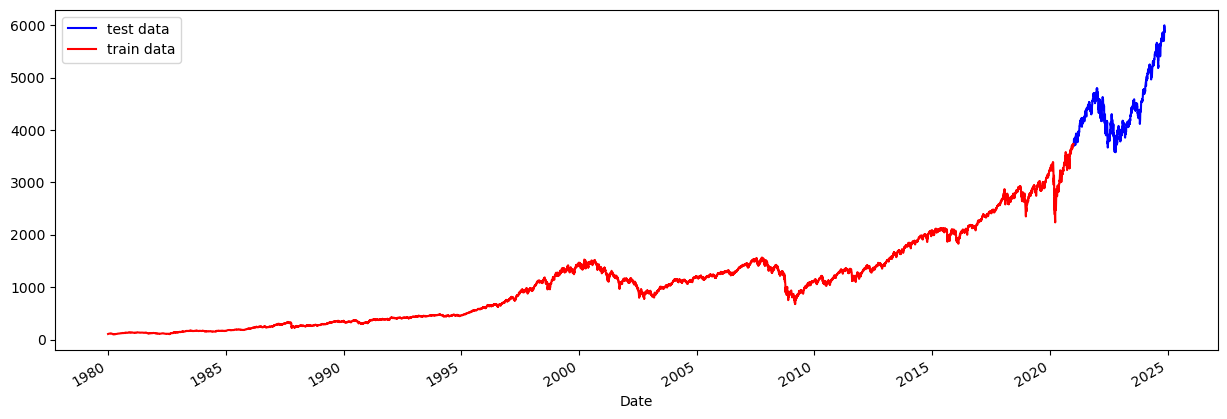

In [174]:
## Visualize Training Data(red) and Testing Data(blue)
fig, ax = plt.subplots(figsize = (15,5))
test.Close.plot(ax = ax, label="test data", color = "blue")
train.Close.plot(ax = ax, label="train data", color = "red")
ax.legend()

#### generating input X and output Y for both test and train data 

In [177]:
# Accepts TRAIN data and returns X and Y
def separateTrainXY(train_data, features, target):
    FEATURES = features
    TARGET = target
    x_train = train[FEATURES_TRAIN] 
    y_train = train[TARGET]
    return x_train, y_train

# Accepts TEST data and returns X and Y
def separateTestXY(test_data, features, target):    
    FEATURES_TEST = features
    TARGET = target
    x_test = test[FEATURES_TEST]
    y_test = test[TARGET]
    return x_test, y_test

In [179]:
x_train, y_train = separateTrainXY(train, FEATURES_TRAIN, TARGET)
x_test, y_test = separateTestXY(train, FEATURES_TEST, TARGET)

# Training the Model

In [182]:
model1 = xgb.XGBRegressor(n_estimators=3000, learning_rate = 0.02, max_depth=10)
model1.fit(x_train, y_train, 
           verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [183]:
pd.DataFrame(data = model1.feature_importances_,
            index = FEATURES_TRAIN,
            columns = ["importance"])

importance
quarter      0.000093
year         0.059484
month        0.000108
dayofweek    0.000073
yesterday    0.940241

In [184]:
pd.DataFrame(data = model1.feature_importances_,
            index = FEATURES_TRAIN,
            columns = ["importance"])

importance
quarter      0.000093
year         0.059484
month        0.000108
dayofweek    0.000073
yesterday    0.940241

In [185]:
train

Open         High          Low        Close  \
Date                                                                            
1980-01-02 00:00:00-05:00     0.000000   108.430000   105.290001   105.760002   
1980-01-03 00:00:00-05:00     0.000000   106.080002   103.260002   105.220001   
1980-01-04 00:00:00-05:00     0.000000   107.080002   105.089996   106.519997   
1980-01-07 00:00:00-05:00     0.000000   107.800003   105.800003   106.809998   
1980-01-08 00:00:00-05:00     0.000000   109.290001   106.290001   108.949997   
...                                ...          ...          ...          ...   
2020-12-23 00:00:00-05:00  3693.419922  3711.239990  3689.280029  3690.010010   
2020-12-24 00:00:00-05:00  3694.030029  3703.820068  3689.320068  3703.060059   
2020-12-28 00:00:00-05:00  3723.030029  3740.510010  3723.030029  3735.360107   
2020-12-29 00:00:00-05:00  3750.010010  3756.120117  3723.310059  3727.040039   
2020-12-30 00:00:00-05:00  3736.189941  3744.629883  3730.209961  3732.040039   

                               Volume  Dividends  Stock Splits    yesterday  \
Date                                                                          
1980-01-02 00:00:00-05:00    40610000        0.0           0.0   107.940002   
1980-01-03 00:00:00-05:00    50480000        0.0           0.0   105.760002   
1980-01-04 00:00:00-05:00    39130000        0.0           0.0   105.220001   
1980-01-07 00:00:00-05:00    44500000        0.0           0.0   106.519997   
1980-01-08 00:00:00-05:00    53390000        0.0           0.0   106.809998   
...                               ...        ...           ...          ...   
2020-12-23 00:00:00-05:00  3779160000        0.0           0.0  3687.260010   
2020-12-24 00:00:00-05:00  1883780000        0.0           0.0  3690.010010   
2020-12-28 00:00:00-05:00  3535460000        0.0           0.0  3703.060059   
2020-12-29 00:00:00-05:00  3393290000        0.0           0.0  3735.360107   
2020-12-30 00:00:00-05:00  3154850000        0.0           0.0  3727.040039   

                           quarter  year  month  dayofweek  
Date                                                        
1980-01-02 00:00:00-05:00        1  1980      1          2  
1980-01-03 00:00:00-05:00        1  1980      1          3  
1980-01-04 00:00:00-05:00        1  1980      1          4  
1980-01-07 00:00:00-05:00        1  1980      1          0  
1980-01-08 00:00:00-05:00        1  1980      1          1  
...                            ...   ...    ...        ...  
2020-12-23 00:00:00-05:00        4  2020     12          2  
2020-12-24 00:00:00-05:00        4  2020     12          3  
2020-12-28 00:00:00-05:00        4  2020     12          0  
2020-12-29 00:00:00-05:00        4  2020     12          1  
2020-12-30 00:00:00-05:00        4  2020     12          2  

[10339 rows x 12 columns]

In [186]:
def modelPredict(model_, train, x_test):
    x_test_ = x_test.copy()
    last_close_price = train.iloc[-1].Close

    ## DataFrame to store predictions
    predictions = []

    
    ## Predict day by day
    for i in range(len(x_test_)):
        current_features = x_test_.iloc[[i]].copy()
        
        current_features["yesterday"] = last_close_price


        ## Predict stock price for the current day
        predicted = model_.predict(current_features)
        
        ## temp add to add date exp
        # predicted *
        predictions.append(predicted)
        last_close_price = predicted
    

    pred_list = []
    for i, element in enumerate(predictions):
        pred_list.append(element[0])
    
    x_test_['prediction'] = pred_list
    return x_test_


In [187]:
x_pred_result = modelPredict(model1, train, x_test)

In [188]:
x_pred_result

quarter  year  month  dayofweek   prediction
Date                                                                   
2021-01-04 00:00:00-05:00        1  2021      1          0  3452.242920
2021-01-05 00:00:00-05:00        1  2021      1          1  3361.659424
2021-01-06 00:00:00-05:00        1  2021      1          2  3305.497559
2021-01-07 00:00:00-05:00        1  2021      1          3  3321.195068
2021-01-08 00:00:00-05:00        1  2021      1          4  3283.542236
...                            ...   ...    ...        ...          ...
2024-11-12 00:00:00-05:00        4  2024     11          1  3596.811768
2024-11-13 00:00:00-05:00        4  2024     11          2  3590.029785
2024-11-14 00:00:00-05:00        4  2024     11          3  3559.559082
2024-11-15 00:00:00-05:00        4  2024     11          4  3572.630371
2024-11-18 00:00:00-05:00        4  2024     11          0  3594.152100

[976 rows x 5 columns]

<Axes: xlabel='Date'>

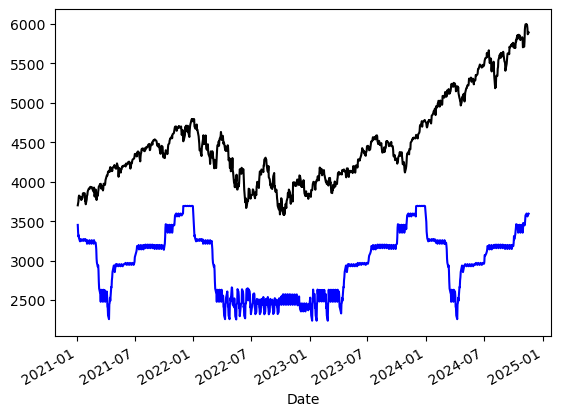

In [189]:
# (ax = ax, label="test data", color = "blue")
ax = test['Close'].plot( color = "black")
x_pred_result['prediction'].plot(ax=ax, color = "blue")
# plt.show()

In [190]:
model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.02, max_depth=10)
model2.fit(x_train, y_train, 
           verbose = True)
x_pred_result2 = modelPredict(model2, test, x_test)

<Axes: xlabel='Date'>

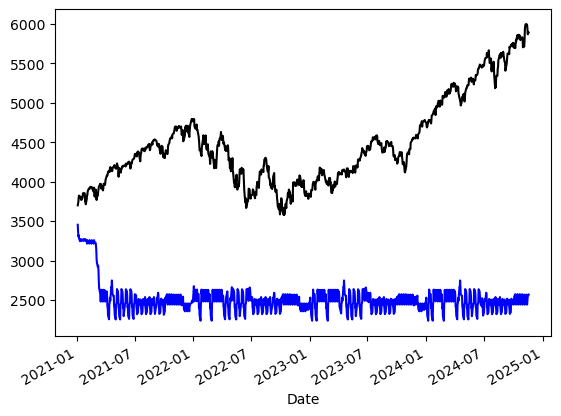

In [191]:
# (ax = ax, label="test data", color = "blue")
ax = test['Close'].plot( color = "black")
x_pred_result2['prediction'].plot(ax=ax, color = "blue")
# plt.show()

In [192]:
x_pred_result2

quarter  year  month  dayofweek   prediction
Date                                                                   
2021-01-04 00:00:00-05:00        1  2021      1          0  3454.172119
2021-01-05 00:00:00-05:00        1  2021      1          1  3363.197021
2021-01-06 00:00:00-05:00        1  2021      1          2  3305.844482
2021-01-07 00:00:00-05:00        1  2021      1          3  3321.654541
2021-01-08 00:00:00-05:00        1  2021      1          4  3283.559082
...                            ...   ...    ...        ...          ...
2024-11-12 00:00:00-05:00        4  2024     11          1  2565.372559
2024-11-13 00:00:00-05:00        4  2024     11          2  2440.675781
2024-11-14 00:00:00-05:00        4  2024     11          3  2485.402100
2024-11-15 00:00:00-05:00        4  2024     11          4  2542.908203
2024-11-18 00:00:00-05:00        4  2024     11          0  2567.874756

[976 rows x 5 columns]

In [193]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import folium
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import HTML
from dash import Dash, html, dcc, callback, Output, Input

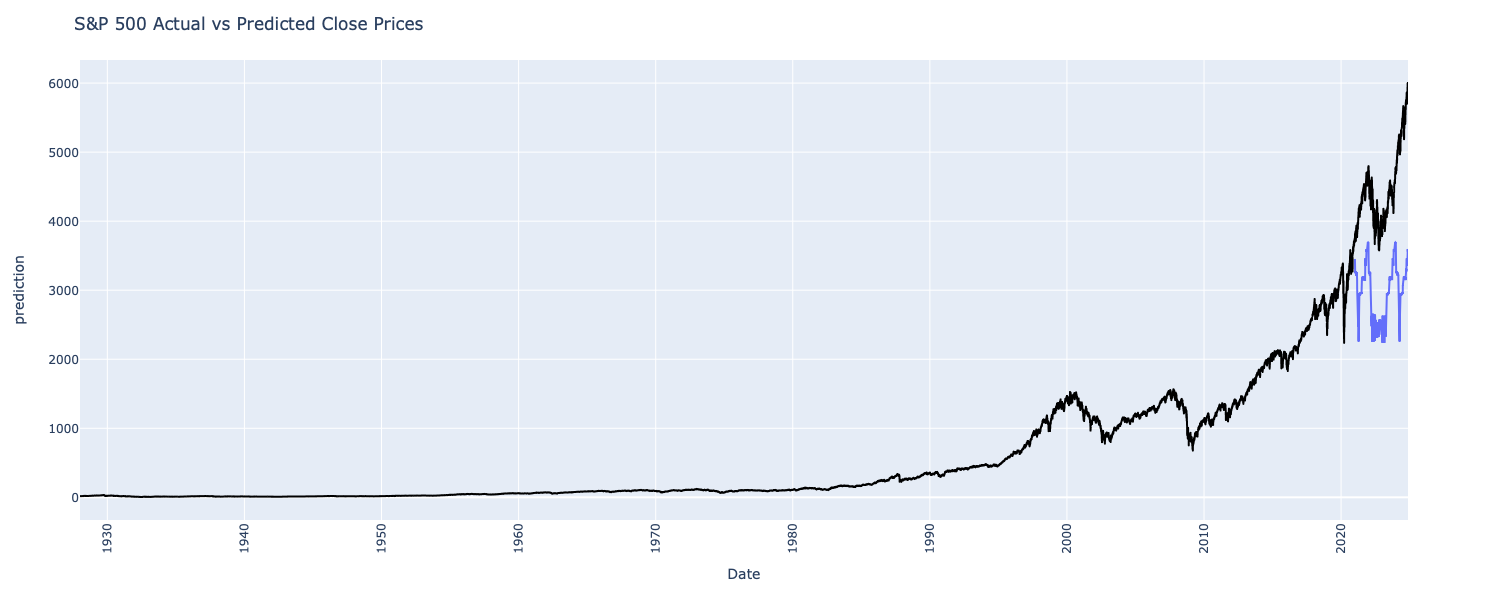

In [194]:
trace = px.line(data_frame = sp500, y = 'Close', color_discrete_sequence=['black'])
fig = px.line(data_frame = x_pred_result, y = 'prediction')
fig.add_trace(trace.data[0])



fig.update_traces(name='Predicted Close', selector=dict(name='y'))
fig.data[1].name = 'Actual Close'

fig.update_layout(
    height=600,
    width=1200,
    title='S&P 500 Actual vs Predicted Close Prices',
    xaxis=dict(tickangle=-90),
    legend_title='Legend'
)

fig.show()
# fig.write_html('model_test.html')

In [195]:
# x_test_curr
def generateFutureDates(days):
    today = pd.to_datetime('today').normalize()
    
    period = days
    pred_range = pd.date_range(start = today, periods = period, freq="D")
    temp_df = pd.DataFrame(index=pred_range)
    temp_df2 = createFeatures(temp_df)
    # print(temp_df)
    temp_df2 = temp_df2[temp_df2['dayofweek'] < 5]
    return temp_df2


In [196]:
train

Open         High          Low        Close  \
Date                                                                            
1980-01-02 00:00:00-05:00     0.000000   108.430000   105.290001   105.760002   
1980-01-03 00:00:00-05:00     0.000000   106.080002   103.260002   105.220001   
1980-01-04 00:00:00-05:00     0.000000   107.080002   105.089996   106.519997   
1980-01-07 00:00:00-05:00     0.000000   107.800003   105.800003   106.809998   
1980-01-08 00:00:00-05:00     0.000000   109.290001   106.290001   108.949997   
...                                ...          ...          ...          ...   
2020-12-23 00:00:00-05:00  3693.419922  3711.239990  3689.280029  3690.010010   
2020-12-24 00:00:00-05:00  3694.030029  3703.820068  3689.320068  3703.060059   
2020-12-28 00:00:00-05:00  3723.030029  3740.510010  3723.030029  3735.360107   
2020-12-29 00:00:00-05:00  3750.010010  3756.120117  3723.310059  3727.040039   
2020-12-30 00:00:00-05:00  3736.189941  3744.629883  3730.209961  3732.040039   

                               Volume  Dividends  Stock Splits    yesterday  \
Date                                                                          
1980-01-02 00:00:00-05:00    40610000        0.0           0.0   107.940002   
1980-01-03 00:00:00-05:00    50480000        0.0           0.0   105.760002   
1980-01-04 00:00:00-05:00    39130000        0.0           0.0   105.220001   
1980-01-07 00:00:00-05:00    44500000        0.0           0.0   106.519997   
1980-01-08 00:00:00-05:00    53390000        0.0           0.0   106.809998   
...                               ...        ...           ...          ...   
2020-12-23 00:00:00-05:00  3779160000        0.0           0.0  3687.260010   
2020-12-24 00:00:00-05:00  1883780000        0.0           0.0  3690.010010   
2020-12-28 00:00:00-05:00  3535460000        0.0           0.0  3703.060059   
2020-12-29 00:00:00-05:00  3393290000        0.0           0.0  3735.360107   
2020-12-30 00:00:00-05:00  3154850000        0.0           0.0  3727.040039   

                           quarter  year  month  dayofweek  
Date                                                        
1980-01-02 00:00:00-05:00        1  1980      1          2  
1980-01-03 00:00:00-05:00        1  1980      1          3  
1980-01-04 00:00:00-05:00        1  1980      1          4  
1980-01-07 00:00:00-05:00        1  1980      1          0  
1980-01-08 00:00:00-05:00        1  1980      1          1  
...                            ...   ...    ...        ...  
2020-12-23 00:00:00-05:00        4  2020     12          2  
2020-12-24 00:00:00-05:00        4  2020     12          3  
2020-12-28 00:00:00-05:00        4  2020     12          0  
2020-12-29 00:00:00-05:00        4  2020     12          1  
2020-12-30 00:00:00-05:00        4  2020     12          2  

[10339 rows x 12 columns]

In [87]:
last_close_price = sp500['Close'].iloc[-1]
print(last_close_price)
six_months = 365//2
df_future = generateFutureDates(six_months)
df_future

5995.5400390625


quarter  year  month  dayofweek
2024-11-11        4  2024     11          0
2024-11-12        4  2024     11          1
2024-11-13        4  2024     11          2
2024-11-14        4  2024     11          3
2024-11-15        4  2024     11          4
...             ...   ...    ...        ...
2025-05-05        2  2025      5          0
2025-05-06        2  2025      5          1
2025-05-07        2  2025      5          2
2025-05-08        2  2025      5          3
2025-05-09        2  2025      5          4

[130 rows x 4 columns]

In [89]:
train

Open         High          Low        Close  \
Date                                                                            
2000-01-03 00:00:00-05:00  1469.250000  1478.000000  1438.359985  1455.219971   
2000-01-04 00:00:00-05:00  1455.219971  1455.219971  1397.430054  1399.420044   
2000-01-05 00:00:00-05:00  1399.420044  1413.270020  1377.680054  1402.109985   
2000-01-06 00:00:00-05:00  1402.109985  1411.900024  1392.099976  1403.449951   
2000-01-07 00:00:00-05:00  1403.449951  1441.469971  1400.729980  1441.469971   
...                                ...          ...          ...          ...   
2022-12-23 00:00:00-05:00  3815.110107  3845.800049  3797.010010  3844.820068   
2022-12-27 00:00:00-05:00  3843.340088  3846.649902  3813.219971  3829.250000   
2022-12-28 00:00:00-05:00  3829.560059  3848.320068  3780.780029  3783.219971   
2022-12-29 00:00:00-05:00  3805.449951  3858.189941  3805.449951  3849.280029   
2022-12-30 00:00:00-05:00  3829.060059  3839.850098  3800.340088  3839.500000   

                               Volume  Dividends  Stock Splits    yesterday  \
Date                                                                          
2000-01-03 00:00:00-05:00   931800000        0.0           0.0  1469.250000   
2000-01-04 00:00:00-05:00  1009000000        0.0           0.0  1455.219971   
2000-01-05 00:00:00-05:00  1085500000        0.0           0.0  1399.420044   
2000-01-06 00:00:00-05:00  1092300000        0.0           0.0  1402.109985   
2000-01-07 00:00:00-05:00  1225200000        0.0           0.0  1403.449951   
...                               ...        ...           ...          ...   
2022-12-23 00:00:00-05:00  2819280000        0.0           0.0  3822.389893   
2022-12-27 00:00:00-05:00  3030300000        0.0           0.0  3844.820068   
2022-12-28 00:00:00-05:00  3083520000        0.0           0.0  3829.250000   
2022-12-29 00:00:00-05:00  3003680000        0.0           0.0  3783.219971   
2022-12-30 00:00:00-05:00  2979870000        0.0           0.0  3849.280029   

                           quarter  year  month  dayofweek  
Date                                                        
2000-01-03 00:00:00-05:00        1  2000      1          0  
2000-01-04 00:00:00-05:00        1  2000      1          1  
2000-01-05 00:00:00-05:00        1  2000      1          2  
2000-01-06 00:00:00-05:00        1  2000      1          3  
2000-01-07 00:00:00-05:00        1  2000      1          4  
...                            ...   ...    ...        ...  
2022-12-23 00:00:00-05:00        4  2022     12          4  
2022-12-27 00:00:00-05:00        4  2022     12          1  
2022-12-28 00:00:00-05:00        4  2022     12          2  
2022-12-29 00:00:00-05:00        4  2022     12          3  
2022-12-30 00:00:00-05:00        4  2022     12          4  

[5787 rows x 12 columns]

In [91]:
# # Make train data but including today's date
# sp_train = sp500.iloc[(sp500.index > '31-12-1999')] 
# train = createFeatures(sp_train)
# x_train = train[FEATURES] 
# y_train = train[TARGET]

In [101]:
sp_train = sp500.iloc[(sp500.index < '01-01-2023')& (sp500.index > '31-12-2005')] 
train = createFeatures(sp_train)
x_train = train[FEATURES] 
y_train = train[TARGET]

In [107]:
model2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = 0.02, max_depth=15)
model2.fit(x_train, y_train, 
           verbose = True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [109]:
## Generate future dates; for the next six months
next_six_M = modelPredict(model2, df_future, last_close_price)

yesterday's close 5995.5400390625
predicted:  [4685.5117]
yesterday's close [4685.5117]
predicted:  [4695.787]
yesterday's close [4695.787]
predicted:  [4674.0664]
yesterday's close [4674.0664]
predicted:  [4704.537]
yesterday's close [4704.537]
predicted:  [4646.28]
yesterday's close [4646.28]
predicted:  [4634.459]
yesterday's close [4634.459]
predicted:  [4598.843]
yesterday's close [4598.843]
predicted:  [4660.506]
yesterday's close [4660.506]
predicted:  [4664.6943]
yesterday's close [4664.6943]
predicted:  [4682.7153]
yesterday's close [4682.7153]
predicted:  [4689.1436]
yesterday's close [4689.1436]
predicted:  [4695.787]
yesterday's close [4695.787]
predicted:  [4674.0664]
yesterday's close [4674.0664]
predicted:  [4704.537]
yesterday's close [4704.537]
predicted:  [4646.28]
yesterday's close [4646.28]
predicted:  [4568.098]
yesterday's close [4568.098]
predicted:  [4649.063]
yesterday's close [4649.063]
predicted:  [4703.1826]
yesterday's close [4703.1826]
predicted:  [4704.96

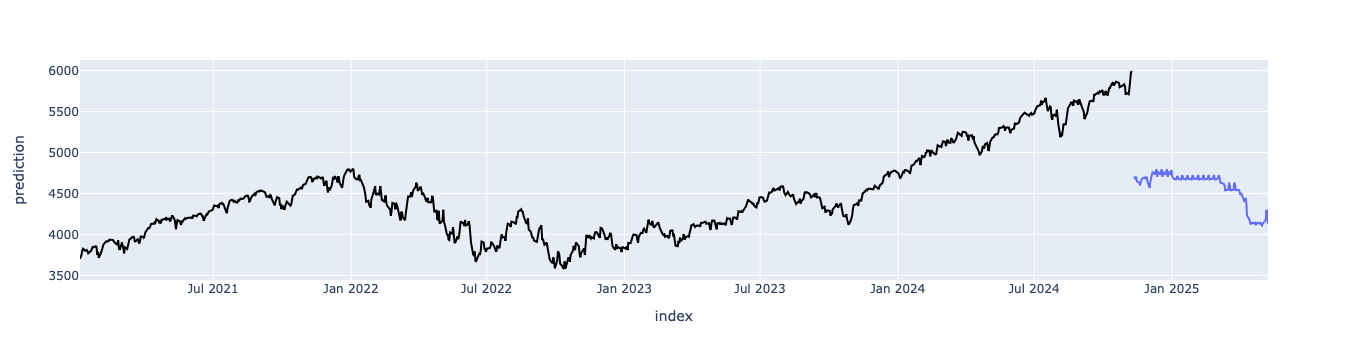

In [111]:
trace = px.line(data_frame = sp500_2021, y = 'Close', color_discrete_sequence=['black'])
fig = px.line(data_frame = next_six_M, y = 'prediction')
fig.add_trace(trace.data[0])
# fig['layout'].update(height = 600, width = 800, title = title,xaxis=dict(
#       tickangle=-90
#     ))
# iplot(fig)
fig.show()
# fig.write_html('future_pred.html')

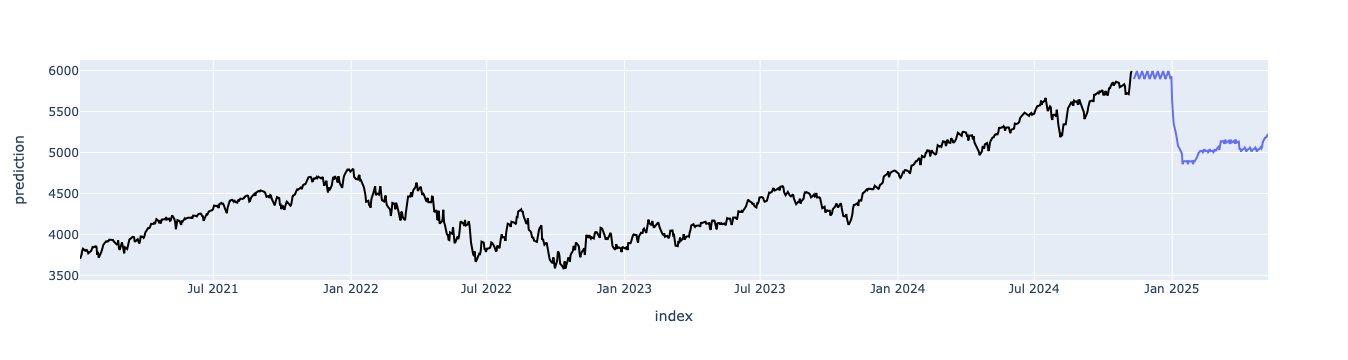

In [99]:
trace = px.line(data_frame = sp500_2021, y = 'Close', color_discrete_sequence=['black'])
fig = px.line(data_frame = next_six_M, y = 'prediction')
fig.add_trace(trace.data[0])
# fig['layout'].update(height = 600, width = 800, title = title,xaxis=dict(
#       tickangle=-90
#     ))
# iplot(fig)
fig.show()
# fig.write_html('future_pred.html')

In [113]:
x_train = train[FEATURES] 
y_train = train[TARGET]
x_test = test[FEATURES_test]
y_test = test[TARGET]

In [115]:
x_pred_result2 = modelPredict(model2, x_test, yesterday_close)

yesterday's close 3839.5
predicted:  [3841.0544]
yesterday's close [3841.0544]
predicted:  [3794.4822]
yesterday's close [3794.4822]
predicted:  [3789.71]
yesterday's close [3789.71]
predicted:  [3776.5986]
yesterday's close [3776.5986]
predicted:  [3792.8796]
yesterday's close [3792.8796]
predicted:  [3817.7456]
yesterday's close [3817.7456]
predicted:  [3847.6738]
yesterday's close [3847.6738]
predicted:  [3871.762]
yesterday's close [3871.762]
predicted:  [3869.4485]
yesterday's close [3869.4485]
predicted:  [3873.0964]
yesterday's close [3873.0964]
predicted:  [3846.2385]
yesterday's close [3846.2385]
predicted:  [3871.762]
yesterday's close [3871.762]
predicted:  [3869.4485]
yesterday's close [3869.4485]
predicted:  [3889.2007]
yesterday's close [3889.2007]
predicted:  [3902.6707]
yesterday's close [3902.6707]
predicted:  [3878.0488]
yesterday's close [3878.0488]
predicted:  [3885.2705]
yesterday's close [3885.2705]
predicted:  [3869.4485]
yesterday's close [3869.4485]
predicted: 

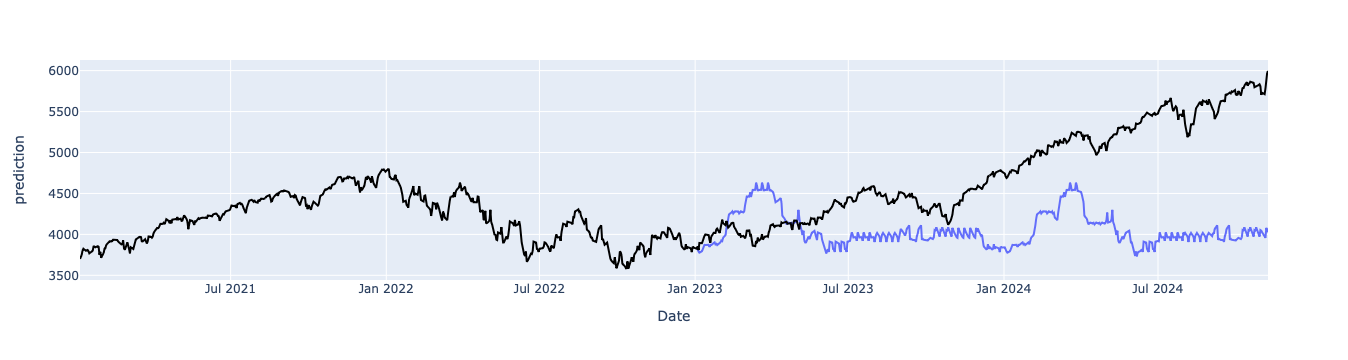

In [117]:
trace = px.line(data_frame = sp500_2021, y = 'Close', color_discrete_sequence=['black'])
fig = px.line(data_frame = x_test, y = 'prediction')
fig.add_trace(trace.data[0])
# fig['layout'].update(height = 600, width = 800, title = title,xaxis=dict(
#       tickangle=-90
#     ))
# iplot(fig)
fig.show()
# fig.write_html('model_test.html')

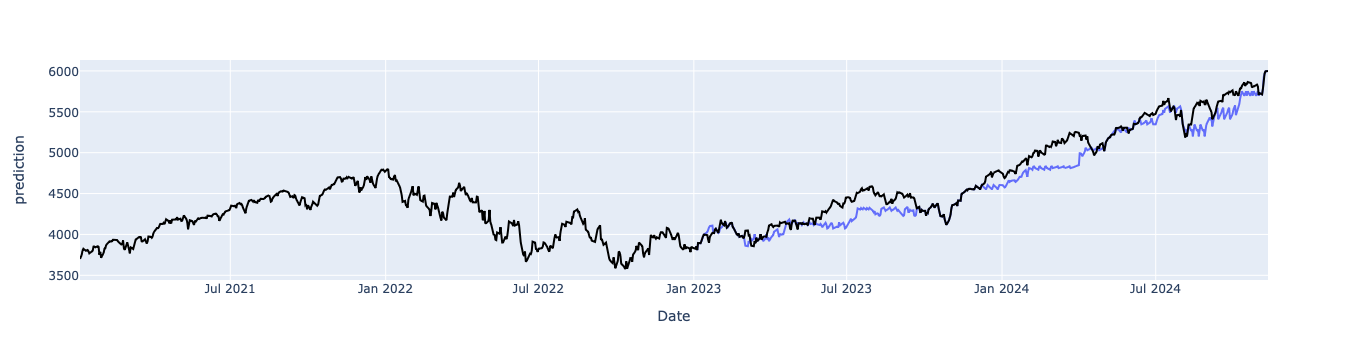

In [123]:
trace = px.line(data_frame = sp500_2021, y = 'Close', color_discrete_sequence=['black'])
fig = px.line(data_frame = x_test, y = 'prediction')
fig.add_trace(trace.data[0])
# fig['layout'].update(height = 600, width = 800, title = title,xaxis=dict(
#       tickangle=-90
#     ))
# iplot(fig)
fig.show()
# fig.write_html('model_test.html')

In [125]:
yesterday_close = y_train[-1]
x_pred_result = modelPredict(model1, x_test, yesterday_close)

ValueError: feature_names mismatch: ['quarter', 'year', 'month', 'dayofweek', 'yesterday'] ['quarter', 'year', 'month', 'dayofweek', 'prediction', 'yesterday']
training data did not have the following fields: prediction